In [ ]:
#algorithms needed: upscaling methods, ksvdbox, ompbox

In [68]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import cv2

Matplotlib is building the font cache; this may take a moment.


In [5]:
ls

aplus_python.ipynb
Aplus_x2_1024atoms2048nn_05mil.mat
Aplus_x2_1024atoms2048nn_5mil.mat
Aplus_x2_16atoms2048nn_05mil.mat
Aplus_x3_1024atoms2048nn_05mil.mat
Aplus_x3_1024atoms2048nn_5mil.mat
Aplus_x3_16atoms2048nn_05mil.mat
Aplus_x4_1024atoms2048nn_05mil.mat
Aplus_x4_1024atoms2048nn_5mil.mat
Aplus_x4_16atoms2048nn_05mil.mat
B100/
calc_PeakSNR.m
collect.m
collectSamplesScales.m
conf.mat
conf_Zeyde_1024_finalx2.mat
conf_Zeyde_1024_finalx3.mat
conf_Zeyde_1024_finalx4.mat
conf_Zeyde_16_finalx2.mat
conf_Zeyde_16_finalx3.mat
conf_Zeyde_16_finalx4.mat
CVPR08-SR/
Example_Zeyde.m
extract.m
glob.m
go_prepare_image_Aplus.m
go_prepare_image.m
go_prepare_images_paper_x3_Aplus.m
go_prepare_images_paper_x3.m
go_run_B100_x2_Aplus1024.m
go_run_B100_x3_Aplus1024.m
go_run_B100_x4_Aplus1024.m
go_run_B100_x4_Aplus1024.m~
go_run_Set14.m
go_run_Set14_x2_Aplus1024.m
go_run_Set14_x3_Aplus1024.m
go_run_Set14_x4_Aplus1024.m
go_run_Set5_x2_Aplus1024.m
go_run_Set5_x2.m
go_run_Set5_x3_Aplus1024.m
go_run_Set5_x3.m
go

In [3]:
ls Set5

baby_GT.bmp  butterfly_GT.bmp  results_Set5_x3_1024atoms/     woman_GT.bmp
bird_GT.bmp  head_GT.bmp       results_Set5_x3_1024atomsRGB/


In [1]:
imgscale = 1
flag = 0
upscaling = 3
clusterszA = 2048

In [51]:
#zeyde configurations
zeyde_conf = scipy.io.loadmat('conf_Zeyde_16_finalx3.mat')
print(len(zeyde_conf['conf'][0][0]))
dict_lores = zeyde_conf['conf'][0][0][10]
dict_hires = zeyde_conf['conf'][0][0][11]
print(dict_lores.shape)
print(dict_hires.shape)

13
(30, 16)
(81, 16)


In [50]:
dict_lores

array([[-1.21683357e-03, -6.42687090e-04,  2.46472142e-04,
        -1.11890653e-03,  1.01464004e-03, -2.48216413e-03,
        -6.01688530e-05,  2.49332160e-03,  8.02565499e-04,
         1.51379685e-03,  1.38091049e-03,  9.64703499e-04,
         5.36819357e-04, -1.14264196e-03,  5.30614195e-04,
         3.28915635e-04],
       [-5.08356360e-04, -8.31705707e-05, -5.65119713e-04,
        -9.58355218e-04,  9.43657570e-05, -4.58853884e-04,
         6.38878915e-04,  7.09007228e-04, -1.21952983e-03,
         2.82468397e-03, -4.11576361e-04,  2.45492865e-04,
        -3.59711126e-04, -4.96176346e-04,  4.60917116e-04,
         2.47203514e-04],
       [-1.23716957e-03, -3.37962096e-03,  3.36091047e-04,
         1.25337578e-03,  1.45433817e-03,  3.17670547e-03,
        -7.55153017e-04, -1.24545673e-03, -4.33348586e-03,
         2.02000356e-03, -1.39884534e-03, -3.60583865e-03,
         3.15641034e-03, -3.08518145e-03, -2.37052601e-04,
         1.47286706e-03],
       [-1.52938206e-03, -1.30025519e

(81, 16)

In [ ]:
llambda = 0.01

In [ ]:
#res{2} = {yima(low{1}, upscaling)}


#patch_size = 3; % patch size for the low resolution input image
#overlap = 2; % overlap between adjacent patches
#lambda = 0.1; % sparsity parameter
#zooming = 3; % zooming factor, if you change this, the dictionary needs to be retrained. #upscaling = 3

#disp('Start superresolution...');
#ReconIm = L1SR(lowIm, zooming, patch_size, overlap, Dh, Dl, lambda, regres);

In [54]:
yima_dict = scipy.io.loadmat('CVPR08-SR/Data/Dictionary/Dictionary.mat')
dict_hires = yima_dict['Dh']
dict_lores = yima_dict['Dl']

In [56]:
dict_lores.shape

(144, 1022)

In [83]:
img = cv2.imread('Set5/baby_GT.bmp') #reads as BGR

In [84]:
img

array([[[251, 254, 252],
        [251, 254, 252],
        [251, 254, 252],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[251, 254, 252],
        [251, 254, 252],
        [251, 254, 252],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[251, 254, 252],
        [251, 254, 252],
        [251, 254, 252],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[ 37,  60,  77],
        [ 45,  68,  85],
        [ 47,  69,  86],
        ...,
        [ 55,  72,  63],
        [ 55,  72,  63],
        [ 55,  72,  63]],

       [[ 30,  51,  68],
        [ 34,  55,  72],
        [ 36,  56,  74],
        ...,
        [ 57,  73,  65],
        [ 56,  73,  64],
        [ 56,  73,  64]],

       [[ 28,  46,  63],
        [ 32,  49,  66],
        [ 33,  50,  67],
        ...,
        [ 58,  75,  66],
        [ 58,  75,  66],
        [ 57,  74,  65]]

In [73]:
img.shape

(512, 512, 3)

In [75]:
img_channel1 = img[:,:,0]

In [80]:
img_channel1

array([[251, 251, 251, ..., 254, 254, 254],
       [251, 251, 251, ..., 254, 254, 254],
       [251, 251, 251, ..., 254, 254, 254],
       ...,
       [ 37,  45,  47, ...,  55,  55,  55],
       [ 30,  34,  36, ...,  57,  56,  56],
       [ 28,  32,  33, ...,  58,  58,  57]], dtype=uint8)

In [85]:
import matplotlib.image as mpimg

img = mpimg.imread('Set5/baby_GT.bmp') #reads as RGB

In [86]:
img

array([[[252, 254, 251],
        [252, 254, 251],
        [252, 254, 251],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[252, 254, 251],
        [252, 254, 251],
        [252, 254, 251],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[252, 254, 251],
        [252, 254, 251],
        [252, 254, 251],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[ 77,  60,  37],
        [ 85,  68,  45],
        [ 86,  69,  47],
        ...,
        [ 63,  72,  55],
        [ 63,  72,  55],
        [ 63,  72,  55]],

       [[ 68,  51,  30],
        [ 72,  55,  34],
        [ 74,  56,  36],
        ...,
        [ 65,  73,  57],
        [ 64,  73,  56],
        [ 64,  73,  56]],

       [[ 63,  46,  28],
        [ 66,  49,  32],
        [ 67,  50,  33],
        ...,
        [ 66,  75,  58],
        [ 66,  75,  58],
        [ 65,  74,  57]]

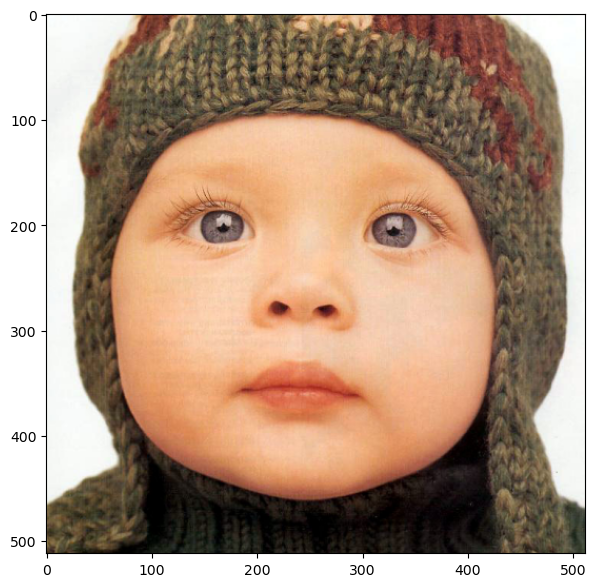

In [82]:
img_rgb = cv2.cvtColor(img,cv2.COLOR_YCrCb2RGB)

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)

#imgplot = ax1.imshow(img_rgb)
#imgplot = ax1.imshow(img_channel1)
imgplot = ax1.imshow(img)

plt.show()

In [72]:
img_rgb

array([[[255, 118, 255],
        [255, 118, 255],
        [255, 118, 255],
        ...,
        [255, 121, 255],
        [255, 121, 255],
        [255, 121, 255]],

       [[255, 118, 255],
        [255, 118, 255],
        [255, 118, 255],
        ...,
        [255, 121, 255],
        [255, 121, 255],
        [255, 121, 255]],

       [[255, 118, 255],
        [255, 118, 255],
        [255, 118, 255],
        ...,
        [255, 121, 255],
        [255, 121, 255],
        [255, 121, 255]],

       ...,

       [[  0, 103,   0],
        [  0, 103,   0],
        [  0, 104,   0],
        ...,
        [  0, 117,   0],
        [  0, 117,   0],
        [  0, 117,   0]],

       [[  0, 106,   0],
        [  0, 105,   0],
        [  0, 106,   0],
        ...,
        [  0, 118,   0],
        [  0, 117,   0],
        [  0, 117,   0]],

       [[  0, 109,   0],
        [  0, 110,   0],
        [  0, 110,   0],
        ...,
        [  0, 117,   0],
        [  0, 117,   0],
        [  0, 117,   0]]

In [59]:
yima_dict = scipy.io.loadmat('CVPR08-SR/Data/Dictionary/Dictionary4.mat')

In [62]:
yima_dict['Dl'].shape

(144, 1024)